In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channels)
transform = transforms.ToTensor()

In [104]:
# Train Data
train_data = datasets.MNIST(root='cnn_data', train=True, download=True, transform=transform)

In [105]:
# Test Data
test_data = datasets.MNIST(root='cnn_data', train=False, download=True, transform=transform)

In [106]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [107]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [108]:
# Create a small batch size for images...let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [109]:
# Define Our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
# This is just an example in the next video we'll build out the actual model
conv1 = nn.Conv2d(1, 6 , 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [110]:
# Grab 1 MNIST record/image
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [111]:
X_Train.shape

torch.Size([1, 28, 28])

In [112]:
x = X_Train.view(1,1,28,28)

In [113]:
x.shape

torch.Size([1, 1, 28, 28])

In [114]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

# 1 single image, 6 is the filters we asked for, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [115]:
# pass thru the pooling layer
x = F.max_pool2d(x,2,2) # kernal of 2 and stride of 2
     
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [116]:
# Do our second convolutional layer
x = F.relu(conv2(x))
     
x.shape # Again, we didn't set padding so we lose 2 pixles around the outside of the image

torch.Size([1, 16, 11, 11])

In [117]:
# Pooling layer
x = F.max_pool2d(x,2,2)

x.shape # 11 / 2 = 5.5 but we have to round down, because you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [118]:
((28-2) / 2 - 2) / 2

5.5

In [119]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [120]:
# Create an Instance of our Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

torch.manual_seed(41)
model = ConvolutionalNetwork()
model = model.to(device)

In [121]:
next(model.parameters()).device

device(type='cuda', index=0)

In [122]:
model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [123]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the Learning Rate, longer its gonna take to train.

In [124]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    X_train = X_train.to(device)
    y_train = y_train.to(device)
      
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train
      
    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      X_test = X_test.to(device)
      y_test = y_test.to(device)
      
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away
        
  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.16228090226650238
Epoch: 0  Batch: 1200  Loss: 0.1436859518289566
Epoch: 0  Batch: 1800  Loss: 0.5350221395492554
Epoch: 0  Batch: 2400  Loss: 0.09874939173460007
Epoch: 0  Batch: 3000  Loss: 0.008747996762394905
Epoch: 0  Batch: 3600  Loss: 0.36597323417663574
Epoch: 0  Batch: 4200  Loss: 0.005636198911815882
Epoch: 0  Batch: 4800  Loss: 0.0016124444082379341
Epoch: 0  Batch: 5400  Loss: 0.043589092791080475
Epoch: 0  Batch: 6000  Loss: 0.00032998353708535433
Epoch: 1  Batch: 600  Loss: 0.004392813425511122
Epoch: 1  Batch: 1200  Loss: 0.15629301965236664
Epoch: 1  Batch: 1800  Loss: 0.003584187477827072
Epoch: 1  Batch: 2400  Loss: 0.0039670392870903015
Epoch: 1  Batch: 3000  Loss: 0.041004590690135956
Epoch: 1  Batch: 3600  Loss: 0.4016276001930237
Epoch: 1  Batch: 4200  Loss: 0.0376506932079792
Epoch: 1  Batch: 4800  Loss: 0.00015720303053967655
Epoch: 1  Batch: 5400  Loss: 0.000122533441754058
Epoch: 1  Batch: 6000  Loss: 0.15041473507881165
Epoch: 2 

In [125]:
train_losses

[tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.1504, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.2094, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.0125, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)]

In [126]:
test_losses

[tensor(0.0027, device='cuda:0'),
 tensor(0.0007, device='cuda:0'),
 tensor(0.0015, device='cuda:0'),
 tensor(0.0091, device='cuda:0'),
 tensor(0.0008, device='cuda:0')]

In [127]:
# Graph the loss at epoch
train_losses = [trl.item() for trl in train_losses]
test_losses = [tel.item() for tel in test_losses]

In [128]:
train_losses

[0.00032998353708535433,
 0.15041473507881165,
 0.20935706794261932,
 0.012476092204451561,
 0.00030460540438070893]

In [129]:
test_losses

[0.0027126725763082504,
 0.0006610665004700422,
 0.0015265227993950248,
 0.00912721548229456,
 0.0008428004803135991]

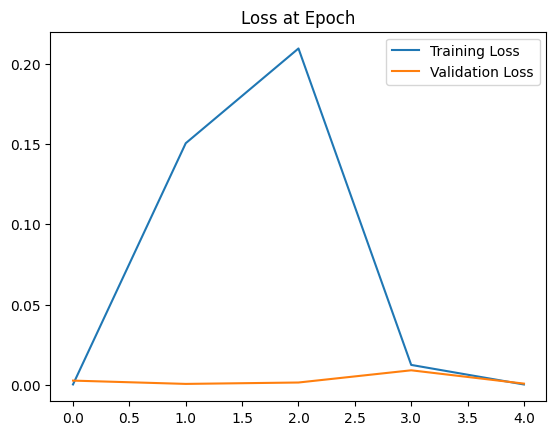

In [130]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

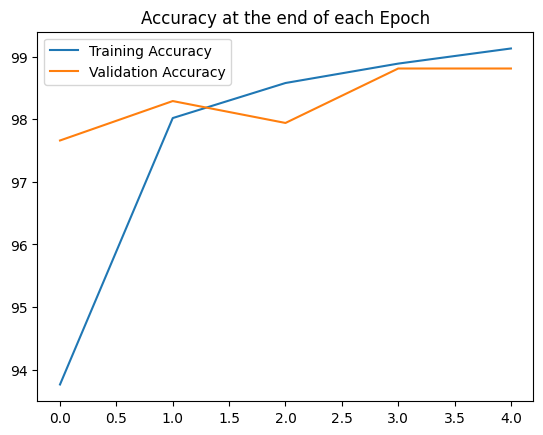

In [131]:
train_correct = [trl.item() for trl in train_correct]
test_correct = [tel.item() for tel in test_correct]

# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [132]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [133]:
model = model.cpu()

In [134]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [135]:
# Did for correct
correct.item()/len(test_data)*100

98.81

In [136]:
test_data[1900]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [137]:
# Grab just the data
test_data[1900][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [138]:
# Reshape it
test_data[1900][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

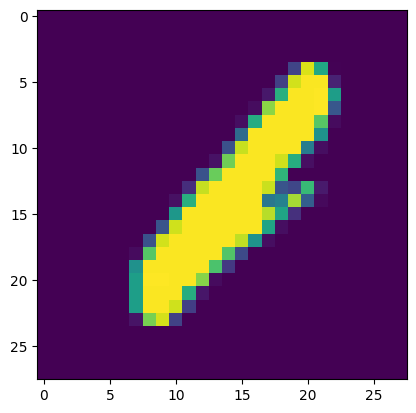

In [139]:
# Show the image
plt.imshow(test_data[1900][0].reshape(28,28))

In [146]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[2000][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image

In [147]:
model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [148]:
# Check the new prediction...get probabilities
new_prediction

tensor([[-1.1690e+01, -1.9177e+01, -1.9023e+01, -1.9078e+01, -2.0815e+01,
         -1.6332e+01, -2.0504e-05, -2.8944e+01, -1.1327e+01, -2.1495e+01]])

In [149]:
new_prediction

tensor([[-1.1690e+01, -1.9177e+01, -1.9023e+01, -1.9078e+01, -2.0815e+01,
         -1.6332e+01, -2.0504e-05, -2.8944e+01, -1.1327e+01, -2.1495e+01]])

In [150]:
new_prediction.argmax()

tensor(6)

In [151]:
# Save our NN Model
torch.save(model.state_dict(), 'my_really_awesome_mnist_model.pt')